In [1]:
import sys; sys.path.append(_dh[0].split("knowknow")[0])
from knowknow import *

# User settings

In [2]:
definitions_of_death = ['death1','death2','death3','death5']

In [3]:
#plt.style.use('grayscale')

In [4]:
linestyles = ['-','--','-.','dotted']

In [5]:
# note: can be externally modified by meta_executor
setting_no = -1

In [6]:
# Parameters
setting_no = 2


In [7]:
if setting_no == 0:
    database_name = 'sociology-wos'
    dtype = 'ta'
    birth_key = 'first'
    print_name = 'author'
    print_names = 'authors'
    print_birth = 'First citation'
    YMIN,YMAX = 1930, 2010

elif setting_no == 1:
    database_name = 'sociology-wos'
    dtype = 'c'
    birth_key = 'first'
    print_name = 'work'
    print_names = 'works'
    print_birth = 'Publication date'
    YMIN,YMAX = 1930, 2010

elif setting_no == 2:
    database_name = 'sociology-jstor'
    dtype = 't'
    birth_key = 'first'
    print_name = 'term'
    print_names = 'terms'
    print_birth = 'First use'
    YMIN,YMAX = 1965, 2010

# Loading the data

In [8]:
ysum = load_variable("%s.%s.ysum" % (database_name,dtype))

In [9]:
list(ysum.items())[:2]

[(('across', 'societies'),
  {'maxprop': 0.004449388209121246,
   'first': 1971,
   'maxcounty': 2015,
   'maxpropy': 2015,
   'last': 2015,
   'death2': None,
   'name': ('across', 'societies'),
   'totalprop': 0.060170277562862175,
   'maxcount': 4,
   'death1': None,
   'total': 56,
   'death3': None,
   'death5': None}),
 (('health', 'care'),
  {'maxprop': 0.058823529411764705,
   'first': 1970,
   'maxcounty': 2007,
   'maxpropy': 2018,
   'last': 2018,
   'death2': None,
   'name': ('health', 'care'),
   'totalprop': 0.9028539363539622,
   'maxcount': 36,
   'death1': None,
   'total': 767,
   'death3': None,
   'death5': None})]

In [10]:
docs = get_cnt("%s.doc" % database_name, keys=[dtype, comb(dtype,'fy'), 'fy'])

Loaded keys: dict_keys(['t', 'fy.t', 'fy'])
Available keys: ['a', 'a.c', 'a.fj.fy', 'c', 'c.c', 'c.fa', 'c.fj', 'c.fy', 'c.t', 'fa', 'fa.fj.fy', 'fj', 'fj.fy', 'fj.t', 'fy', 'fy.t', 't']


In [11]:
cits = get_cnt("%s.ind" % database_name, keys=[dtype, comb(dtype,'fy'), 'fy'])

Loaded keys: dict_keys(['t', 'fy.t', 'fy'])
Available keys: ['a', 'a.c', 'a.fj.fy', 'c', 'c.c', 'c.fa', 'c.fj', 'c.fy', 'c.t', 'fa', 'fa.fj.fy', 'fj', 'fj.fy', 'fj.t', 'fy', 'fy.t', 't']


In [12]:
list(docs[dtype])[:5]

[t(t='across'),
 t(t='health'),
 t(t='social'),
 t(t='consistent'),
 t(t='universal')]

# Number of distinct items cited in each year

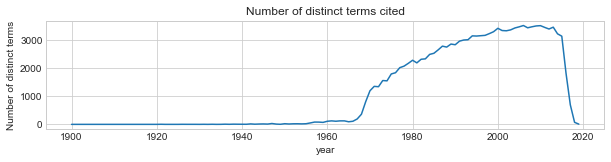

In [13]:
plt.figure(figsize=(10,2))

cc = Counter( cross.fy for cross in cits[comb(dtype, 'fy')] )
years = range(1900,2020)
plt.plot(
    years,
    [cc[x] for x in years]
)
plt.title("Number of distinct %s cited" % print_names)
plt.xlabel("year")
plt.ylabel("Number of distinct %s" % print_names)
save_figure( "Number of distinct %s cited (%s)" % (print_names, database_name) )

# Probability of death based on cohort, YRLOOK

The following plot shows the percent of 

In [14]:
def birthdate_pdead(YRLOOK):

    dying_count = defaultdict(lambda:defaultdict(int))

    step = 5

    # first we go through and count how many publications born in each year are dead before YRLOOK

    # loop through entries
    for k, x in ysum.items():
        for dk in definitions_of_death:
            dying_count[dk][(
                (x[birth_key]//step)*step,
                x[dk] is not None and x[dk] < YRLOOK
            )] += 1

    counts = range((YMIN//step)*step,(YMAX//step)*step,step)

    for i,dk in enumerate(definitions_of_death):
        probs = [ 
            dying_count[dk][(c,True)] / (dying_count[dk][(c,True)]+dying_count[dk][(c,False)])     
            if (dying_count[dk][(c,True)]+dying_count[dk][(c,False)]>0) else 0 
            for c in counts 
        ]
        plt.plot(counts,probs,label=dk,linestyle=linestyles[i], color='black')

    plt.xlabel("birth date")
    plt.ylabel("P(dead by %s)" % YRLOOK)
    plt.legend();
    plt.ylim(0,1)
    
    save_figure("Probability of cited %s death by %s, by cohort (%s)" % (print_name, YRLOOK, database_name) )

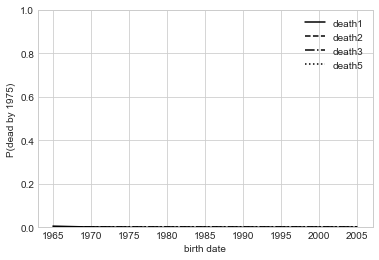

In [15]:
birthdate_pdead(1975)

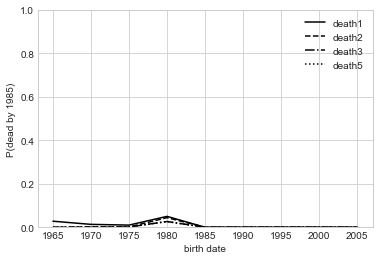

In [16]:
birthdate_pdead(1985)

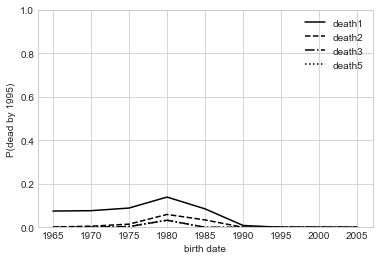

In [17]:
birthdate_pdead(1995)

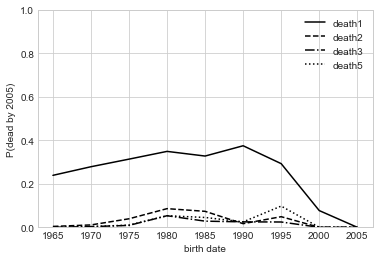

In [18]:
birthdate_pdead(2005)

# age distribution, depending on when you're looking from

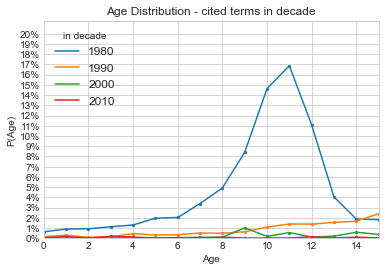

In [20]:
for YRLOOK in range(1980,2020,10):

    born = lambda x: x[birth_key]
    died = lambda x: x[death_key]

    cits_in_range = defaultdict(int)

    for cross, count in cits[ comb(dtype, 'fy') ].items():
        if getattr(cross,dtype) not in ysum:
            continue
        if not( YRLOOK <= cross.fy <= YRLOOK+5 ):
            continue
        cits_in_range[ ysum[ getattr(cross,dtype) ][birth_key] ] += count

    years = range(0,100,1)
    props = np.array([
        cits_in_range[YRLOOK - x] for x in years  # transform to ages
    ])
    props = props/np.sum(props)
    props *= 100

    plt.plot(
        years,
        props,
        #label="%s (%s)" % (YRLOOK,num)
        label=YRLOOK
    );
    plt.scatter(years,props,s=5)

plt.title("Age Distribution - cited %s in decade" % print_names)
plt.xlim((-5,30))
plt.ylim((0,plt.ylim()[1]*1.2))
plt.yticks(
    range(0,int(plt.ylim()[1]),1),
    ["%s%%"%x for x in range(0,int(plt.ylim()[1]),1)]
)
plt.ylabel("P(Age)")
plt.xlabel("Age")
lgnd = plt.legend(fancybox=True, title='in decade', prop={'size': 12})

for h in lgnd.legendHandles:
    h._sizes = [30]

plt.xlim((0,15))
    
save_figure("Cited %s age distribution, by decade of citation (%s)" % (print_name, database_name))
#plt.legend()
plt.show()

# proportion dead based from each cohort

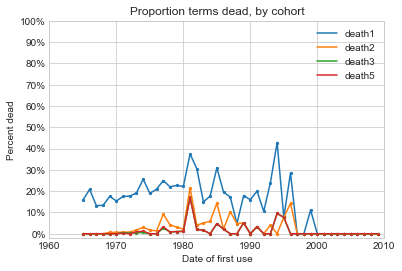

In [21]:
YLOOK = 2000

for death_key in definitions_of_death:

    born = lambda x: x[birth_key]
    died = lambda x: x[death_key]

    years = range(YMIN,YMAX)
    pdied = {
        y: Counter( (died(x) is not None and died(x)<=YLOOK) for x in ysum.values() if x['first']==y ) + 
            Counter( "total" for x in ysum.values() if x['first']==y )
        for y in years
    }

    props = np.array([ pdied[y][True]/pdied[y]['total'] if pdied[y]['total']>0 else np.nan for y in years ])

    plt.plot(
        years,
        props*100,
        label=death_key
    );
    plt.scatter(years,props*100,s=5)
    #plt.errorbar(years,percents,se*100)

plt.title("Proportion %s dead, by cohort" % print_names.lower())
plt.yticks(
    range(0,110,10),
    ["%s%%"%x for x in range(0,110,10)]
)
plt.ylabel("Percent dead")
plt.xlabel("Date of %s" % print_birth.lower())

plt.xlim(1960,YMAX)


plt.legend()

save_figure("Proportion of %s dead by %s, by cohort (%s)" % (print_names.lower(), YLOOK, database_name))
plt.show()

In [20]:
# this analysis doesn't make sense for terms or people
if dtype == 'c':

    cc = Counter(x['first'] - x['pub'] for x in ysum.values() )
    x = range(0,20,1)
    plt.bar(
        x,
        [cc[xx] for xx in x],
        1,
        alpha=0.1
    )

    plt.bar(
        x,
        [cc[xx] for xx in x],
        1,
        color='black',
        fill=False,
        linestyle='-'
    )

    ys = range(0,70000, 10000)
    plt.yticks(
        ys,
        ["%dk"%(x//1000) for x in ys]
    )

    plt.xticks(
        range(0,21,1)
    );

    plt.grid(False, axis='x')

    plt.ylabel("Number of works")
    plt.xlabel("Number of years until %s"%print_birth.lower());

    save_figure("Sleeping beauties - between pub and first (%s)"%(database_name))